# High School Timetabling: Basic Model

This notebook demonstrates **3D multi-model indexing** in LumiX through a classic course scheduling problem - assigning lectures to timeslots and classrooms.

## Problem Description

A high school needs to create a weekly timetable that assigns lectures (teacher-subject-class combinations) to specific timeslots and classrooms. The schedule must ensure:

- Each lecture is scheduled exactly once
- No classroom conflicts (one lecture per room per timeslot)
- No teacher conflicts (teacher can't teach two lectures simultaneously)
- No class conflicts (class can't attend two lectures simultaneously)
- Classroom capacity is sufficient for class size

## Mathematical Formulation

**Decision Variables:**
$$x_{l,t,r} \in \{0, 1\} \quad \text{lecture } l \text{ assigned to timeslot } t \text{ in room } r$$

**Objective:**
This is a **feasibility problem** - find any valid schedule that satisfies all constraints.

**Subject to:**
$$\sum_{t,r} x_{l,t,r} = 1 \quad \forall l \text{ (each lecture assigned once)}$$
$$\sum_{l} x_{l,t,r} \leq 1 \quad \forall t,r \text{ (no room conflicts)}$$
$$\sum_{l \in L_{teacher}, r} x_{l,t,r} \leq 1 \quad \forall t \text{ (no teacher conflicts)}$$
$$\sum_{l \in L_{class}, r} x_{l,t,r} \leq 1 \quad \forall t \text{ (no class conflicts)}$$
$$x_{l,t,r} = 0 \quad \text{if class size} > \text{room capacity}$$

## Key LumiX Features

- **3D multi-model indexing**: `LXVariable[Tuple[Lecture, TimeSlot, Classroom], int]`
- **Cartesian product**: Variables indexed by (Lecture × TimeSlot × Classroom)
- **Filtering with `where_multi()`**: Exclude infeasible assignments
- **Multi-dimensional constraints**: Sum over specific dimensions

## 1. Setup and Imports

In [1]:
# Standard library
from dataclasses import dataclass
from typing import Tuple, List, Dict

# Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# LumiX optimization library
from lumix import LXConstraint, LXLinearExpression, LXModel, LXOptimizer, LXVariable
from lumix.indexing import LXIndexDimension

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

## 2. Data Definition

We define data classes for our timetabling entities and create sample data for a small high school.

In [2]:
@dataclass
class Teacher:
    """A teacher in the school."""
    id: int
    name: str


@dataclass
class Classroom:
    """A classroom with limited capacity."""
    id: int
    name: str
    capacity: int


@dataclass
class SchoolClass:
    """A class (group of students)."""
    id: int
    name: str
    size: int


@dataclass
class Subject:
    """A subject taught in the school."""
    id: int
    name: str


@dataclass
class Lecture:
    """A single lecture session (teacher teaches subject to class)."""
    id: int
    subject_id: int
    teacher_id: int
    class_id: int


@dataclass
class TimeSlot:
    """A time slot in the weekly schedule."""
    id: int
    day_of_week: int  # 0=Monday, 4=Friday
    period: int       # 1-6
    day_name: str

In [3]:
# Teachers
TEACHERS = [
    Teacher(1, "Dr. Smith"),
    Teacher(2, "Prof. Johnson"),
    Teacher(3, "Ms. Williams"),
    Teacher(4, "Mr. Brown"),
    Teacher(5, "Dr. Davis"),
]

# Classrooms
CLASSROOMS = [
    Classroom(1, "Room 101", 30),
    Classroom(2, "Room 102", 30),
    Classroom(3, "Room 201", 25),
    Classroom(4, "Lab A", 20),
]

# School Classes
CLASSES = [
    SchoolClass(1, "9A", 25),
    SchoolClass(2, "9B", 28),
    SchoolClass(3, "10A", 24),
    SchoolClass(4, "10B", 26),
]

# Subjects
SUBJECTS = [
    Subject(1, "Math"),
    Subject(2, "English"),
    Subject(3, "Physics"),
    Subject(4, "Chemistry"),
    Subject(5, "History"),
]

# Generate timeslots (5 days x 6 periods = 30)
DAY_NAMES = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
TIMESLOTS = []
slot_id = 1
for day in range(5):
    for period in range(1, 7):
        TIMESLOTS.append(TimeSlot(slot_id, day, period, DAY_NAMES[day]))
        slot_id += 1

# Lectures (teacher-subject-class combinations)
LECTURES = [
    # Math lectures (Dr. Smith)
    Lecture(1, 1, 1, 1),   # Math for 9A
    Lecture(2, 1, 1, 1),   # Math for 9A (2nd)
    Lecture(3, 1, 1, 2),   # Math for 9B
    Lecture(4, 1, 1, 2),   # Math for 9B (2nd)
    # English lectures (Prof. Johnson)
    Lecture(5, 2, 2, 1),   # English for 9A
    Lecture(6, 2, 2, 2),   # English for 9B
    Lecture(7, 2, 2, 3),   # English for 10A
    # Physics lectures (Ms. Williams)
    Lecture(8, 3, 3, 3),   # Physics for 10A
    Lecture(9, 3, 3, 3),   # Physics for 10A (2nd)
    Lecture(10, 3, 3, 4),  # Physics for 10B
    Lecture(11, 3, 3, 4),  # Physics for 10B (2nd)
    # Chemistry lectures (Mr. Brown)
    Lecture(12, 4, 4, 3),  # Chemistry for 10A
    Lecture(13, 4, 4, 4),  # Chemistry for 10B
    # History lectures (Dr. Davis)
    Lecture(14, 5, 5, 1),  # History for 9A
    Lecture(15, 5, 5, 2),  # History for 9B
    Lecture(16, 5, 5, 3),  # History for 10A
    Lecture(17, 5, 5, 4),  # History for 10B
    # Additional Math (Dr. Smith)
    Lecture(18, 1, 1, 3),  # Math for 10A
    Lecture(19, 1, 1, 4),  # Math for 10B
    # Additional English (Prof. Johnson)
    Lecture(20, 2, 2, 4),  # English for 10B
]

# Helper lookup dictionaries
TEACHER_BY_ID = {t.id: t for t in TEACHERS}
SUBJECT_BY_ID = {s.id: s for s in SUBJECTS}
CLASS_BY_ID = {c.id: c for c in CLASSES}
CLASSROOM_BY_ID = {r.id: r for r in CLASSROOMS}

print(f"Teachers: {len(TEACHERS)}")
print(f"Classrooms: {len(CLASSROOMS)}")
print(f"Classes: {len(CLASSES)}")
print(f"Subjects: {len(SUBJECTS)}")
print(f"Lectures: {len(LECTURES)}")
print(f"Timeslots: {len(TIMESLOTS)} (5 days x 6 periods)")

Teachers: 5
Classrooms: 4
Classes: 4
Subjects: 5
Lectures: 20
Timeslots: 30 (5 days x 6 periods)


### Data Summary Tables

In [4]:
# Teachers and their subjects
teacher_subject_map = {}
for lec in LECTURES:
    teacher_name = TEACHER_BY_ID[lec.teacher_id].name
    subject_name = SUBJECT_BY_ID[lec.subject_id].name
    teacher_subject_map[teacher_name] = subject_name

teacher_df = pd.DataFrame([
    {'Teacher': t.name, 'Subject': teacher_subject_map.get(t.name, '-')}
    for t in TEACHERS
])
print("Teachers and Subjects:")
display(teacher_df.set_index('Teacher'))

# Classrooms
room_df = pd.DataFrame([{'Room': r.name, 'Capacity': r.capacity} for r in CLASSROOMS])
print("\nClassrooms:")
display(room_df.set_index('Room'))

# Classes
class_df = pd.DataFrame([{'Class': c.name, 'Students': c.size} for c in CLASSES])
print("\nSchool Classes:")
display(class_df.set_index('Class'))

Teachers and Subjects:


,Subject
Teacher,
Dr. Smith,Math
Prof. Johnson,English
Ms. Williams,Physics
Mr. Brown,Chemistry
Dr. Davis,History



Classrooms:


,Capacity
Room,
Room 101,30
Room 102,30
Room 201,25
Lab A,20



School Classes:


,Students
Class,
9A,25
9B,28
10A,24
10B,26


### Visualize Data

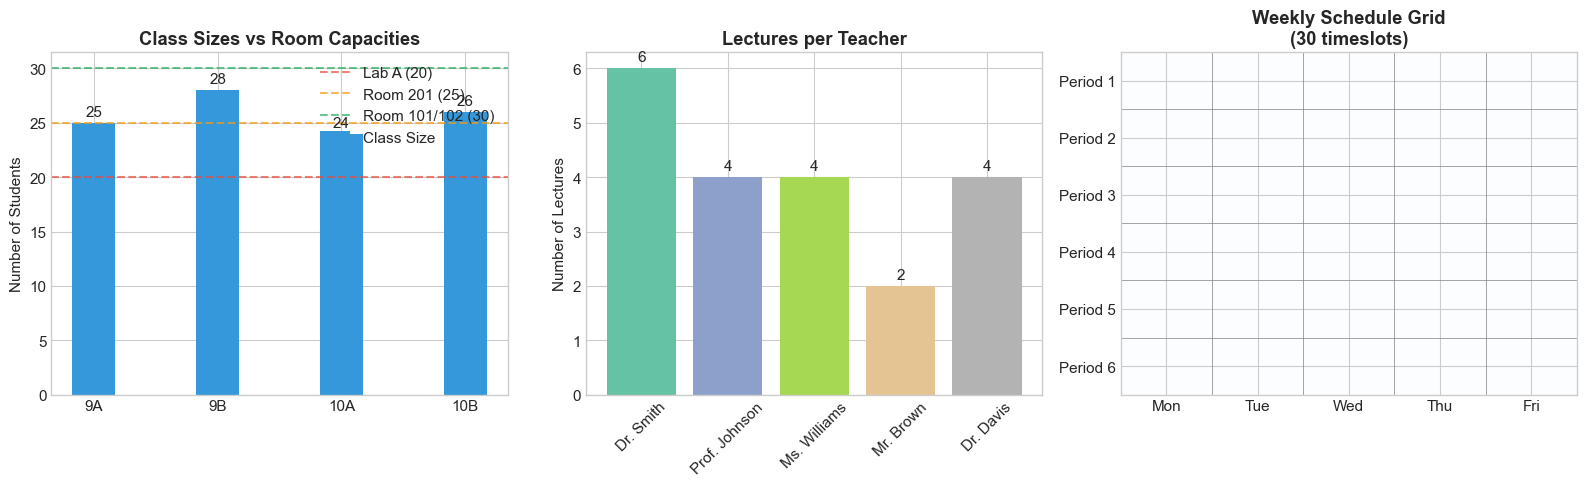

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Classroom Capacity vs Class Size
ax1 = axes[0]
x = np.arange(len(CLASSES))
width = 0.35
class_sizes = [c.size for c in CLASSES]
room_caps = [max(r.capacity for r in CLASSROOMS)] * len(CLASSES)  # Max room capacity line

bars = ax1.bar(x, class_sizes, width, label='Class Size', color='#3498db')
ax1.axhline(y=20, color='#e74c3c', linestyle='--', label='Lab A (20)', alpha=0.7)
ax1.axhline(y=25, color='#f39c12', linestyle='--', label='Room 201 (25)', alpha=0.7)
ax1.axhline(y=30, color='#27ae60', linestyle='--', label='Room 101/102 (30)', alpha=0.7)

ax1.set_ylabel('Number of Students')
ax1.set_title('Class Sizes vs Room Capacities', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([c.name for c in CLASSES])
ax1.legend(loc='upper right')
ax1.bar_label(bars, padding=3)

# 2. Lectures per Teacher
ax2 = axes[1]
teacher_lecture_count = {}
for lec in LECTURES:
    name = TEACHER_BY_ID[lec.teacher_id].name
    teacher_lecture_count[name] = teacher_lecture_count.get(name, 0) + 1

names = list(teacher_lecture_count.keys())
counts = list(teacher_lecture_count.values())
colors = plt.cm.Set2(np.linspace(0, 1, len(names)))

bars2 = ax2.bar(names, counts, color=colors)
ax2.set_ylabel('Number of Lectures')
ax2.set_title('Lectures per Teacher', fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.bar_label(bars2, padding=3)

# 3. Timeslot Grid
ax3 = axes[2]
grid = np.ones((6, 5))  # 6 periods x 5 days
im = ax3.imshow(grid, cmap='Blues', aspect='auto', alpha=0.3)

ax3.set_xticks(np.arange(5))
ax3.set_yticks(np.arange(6))
ax3.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri'])
ax3.set_yticklabels([f'Period {i+1}' for i in range(6)])
ax3.set_title(f'Weekly Schedule Grid\n(30 timeslots)', fontweight='bold')

# Add grid lines
for i in range(7):
    ax3.axhline(y=i-0.5, color='gray', linewidth=0.5)
for i in range(6):
    ax3.axvline(x=i-0.5, color='gray', linewidth=0.5)

plt.tight_layout()
plt.show()

## 3. Build the Optimization Model

The key feature is **3D multi-model indexing**: variables are indexed by `(Lecture, TimeSlot, Classroom)` tuples.

In [6]:
def check_class_fits_classroom(class_id: int, classroom_id: int) -> bool:
    """Check if a class can fit in a classroom."""
    school_class = CLASS_BY_ID.get(class_id)
    classroom = CLASSROOM_BY_ID.get(classroom_id)
    if school_class and classroom:
        return school_class.size <= classroom.capacity
    return False


def build_timetabling_model() -> Tuple[LXModel, LXVariable]:
    """
    Build the timetabling model with 3D multi-model indexing.
    
    Key pattern: Variables indexed by (Lecture x TimeSlot x Classroom)
    """
    
    # 3D Binary Variable: assignment[lecture, timeslot, classroom]
    # 1 if lecture is assigned to timeslot in classroom, 0 otherwise
    assignment = (
        LXVariable[Tuple[Lecture, TimeSlot, Classroom], int]("assignment")
        .binary()
        .indexed_by_product(
            LXIndexDimension(Lecture, lambda lec: lec.id).from_data(LECTURES),
            LXIndexDimension(TimeSlot, lambda ts: ts.id).from_data(TIMESLOTS),
            LXIndexDimension(Classroom, lambda room: room.id).from_data(CLASSROOMS),
        )
        # Filter: only create variables where class fits in room
        .where_multi(
            lambda lec, ts, room: check_class_fits_classroom(lec.class_id, room.id)
        )
    )

    # Create model
    model = LXModel("high_school_timetabling").add_variable(assignment)

    # CONSTRAINT 1: Each lecture assigned exactly once
    for lecture in LECTURES:
        expr = LXLinearExpression().add_multi_term(
            assignment,
            coeff=lambda lec, ts, room: 1.0,
            where=lambda lec, ts, room, curr_lec=lecture: lec.id == curr_lec.id,
        )
        model.add_constraint(
            LXConstraint(f"lecture_{lecture.id}_coverage").expression(expr).eq().rhs(1)
        )

    # CONSTRAINT 2: No classroom conflicts (max 1 lecture per room per timeslot)
    for timeslot in TIMESLOTS:
        for classroom in CLASSROOMS:
            expr = LXLinearExpression().add_multi_term(
                assignment,
                coeff=lambda lec, ts, room: 1.0,
                where=lambda lec, ts, room, curr_ts=timeslot, curr_room=classroom:
                    ts.id == curr_ts.id and room.id == curr_room.id,
            )
            model.add_constraint(
                LXConstraint(f"room_{classroom.id}_slot_{timeslot.id}")
                .expression(expr).le().rhs(1)
            )

    # CONSTRAINT 3: No teacher conflicts
    for teacher in TEACHERS:
        teacher_lecture_ids = [lec.id for lec in LECTURES if lec.teacher_id == teacher.id]
        
        for timeslot in TIMESLOTS:
            expr = LXLinearExpression().add_multi_term(
                assignment,
                coeff=lambda lec, ts, room: 1.0,
                where=lambda lec, ts, room, curr_ts=timeslot, t_lecs=teacher_lecture_ids:
                    ts.id == curr_ts.id and lec.id in t_lecs,
            )
            model.add_constraint(
                LXConstraint(f"teacher_{teacher.id}_slot_{timeslot.id}")
                .expression(expr).le().rhs(1)
            )

    # CONSTRAINT 4: No class conflicts
    for school_class in CLASSES:
        class_lecture_ids = [lec.id for lec in LECTURES if lec.class_id == school_class.id]
        
        for timeslot in TIMESLOTS:
            expr = LXLinearExpression().add_multi_term(
                assignment,
                coeff=lambda lec, ts, room: 1.0,
                where=lambda lec, ts, room, curr_ts=timeslot, c_lecs=class_lecture_ids:
                    ts.id == curr_ts.id and lec.id in c_lecs,
            )
            model.add_constraint(
                LXConstraint(f"class_{school_class.id}_slot_{timeslot.id}")
                .expression(expr).le().rhs(1)
            )

    return model, assignment


# Build the model
model, assignment = build_timetabling_model()

print("Model Summary:")
print("=" * 50)
print(model.summary())

Model Summary:
LXModel: high_school_timetabling
  Variable Families: 1
  Constraint Families: 410
  Objective: max



## 4. Solve the Model

In [7]:
# Create optimizer with OR-Tools solver
optimizer = LXOptimizer().use_solver("ortools")

print("Solving timetabling problem...")
solution = optimizer.solve(model)

print(f"\nSolution Status: {solution.status}")
print(f"Solve Time: {solution.solve_time:.3f}s")

2025-12-12 18:50:51 - lumix.optimizer - INFO - Created model 'high_school_timetabling' with 1 variables and 410 constraints
2025-12-12 18:50:51 - lumix.optimizer - INFO - Starting solve with ortools...


Solving timetabling problem...


2025-12-12 18:50:51 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 0.0000 | Time: 0.19s



Solution Status: optimal
Solve Time: 0.014s


## 5. Analyze the Results

In [8]:
# Extract schedule data
schedule_data = {}
for (lecture_id, timeslot_id, classroom_id), value in solution.get_mapped(assignment).items():
    if value > 0.5:
        schedule_data[(lecture_id, timeslot_id, classroom_id)] = 1

print(f"Total assignments: {len(schedule_data)}")
print(f"Expected (lectures): {len(LECTURES)}")

Total assignments: 20
Expected (lectures): 20


In [9]:
# Create assignment DataFrame
assignments_list = []
for (lecture_id, timeslot_id, classroom_id), value in schedule_data.items():
    lecture = next(l for l in LECTURES if l.id == lecture_id)
    timeslot = next(t for t in TIMESLOTS if t.id == timeslot_id)
    classroom = CLASSROOM_BY_ID[classroom_id]
    
    assignments_list.append({
        'Lecture': lecture_id,
        'Subject': SUBJECT_BY_ID[lecture.subject_id].name,
        'Teacher': TEACHER_BY_ID[lecture.teacher_id].name,
        'Class': CLASS_BY_ID[lecture.class_id].name,
        'Day': timeslot.day_name,
        'Period': timeslot.period,
        'Room': classroom.name,
    })

schedule_df = pd.DataFrame(assignments_list).sort_values(['Day', 'Period', 'Room'])

print("Schedule Assignments:")
display(schedule_df)

Schedule Assignments:


,Lecture,Subject,Teacher,Class,Day,Period,Room
0,1,Math,Dr. Smith,9A,Monday,1,Room 101
7,8,Physics,Ms. Williams,10A,Monday,1,Room 102
1,2,Math,Dr. Smith,9A,Monday,2,Room 101
8,9,Physics,Ms. Williams,10A,Monday,2,Room 102
4,5,English,Prof. Johnson,9A,Monday,3,Room 101
15,16,History,Dr. Davis,10A,Monday,3,Room 102
6,7,English,Prof. Johnson,10A,Monday,4,Room 101
13,14,History,Dr. Davis,9A,Monday,4,Room 102
17,18,Math,Dr. Smith,10A,Monday,5,Room 101
9,10,Physics,Ms. Williams,10B,Monday,5,Room 102


## 6. Visualize the Timetables

In [10]:
def create_timetable_matrix(entity_type: str, entity_id: int, entity_name: str):
    """
    Create a timetable matrix for a teacher or class.
    
    Args:
        entity_type: 'teacher' or 'class'
        entity_id: ID of the teacher or class
        entity_name: Name for display
    
    Returns:
        2D numpy array (6 periods x 5 days) with cell contents
    """
    grid = [["" for _ in range(5)] for _ in range(6)]  # 6 periods x 5 days
    
    # Get relevant lectures
    if entity_type == 'teacher':
        relevant_lectures = [l for l in LECTURES if l.teacher_id == entity_id]
    else:  # class
        relevant_lectures = [l for l in LECTURES if l.class_id == entity_id]
    
    # Fill grid
    for lecture in relevant_lectures:
        for timeslot in TIMESLOTS:
            for classroom in CLASSROOMS:
                key = (lecture.id, timeslot.id, classroom.id)
                if schedule_data.get(key, 0) == 1:
                    subject = SUBJECT_BY_ID[lecture.subject_id].name
                    if entity_type == 'teacher':
                        class_name = CLASS_BY_ID[lecture.class_id].name
                        cell = f"{subject}\n{class_name}\n{classroom.name}"
                    else:
                        teacher = TEACHER_BY_ID[lecture.teacher_id].name.split()[-1]  # Last name
                        cell = f"{subject}\n{teacher}\n{classroom.name}"
                    grid[timeslot.period - 1][timeslot.day_of_week] = cell
    
    return grid


def plot_timetable(grid, title):
    """Plot a timetable as a colored grid."""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Create color matrix (1 if occupied, 0 if empty)
    color_matrix = np.array([[1 if cell else 0 for cell in row] for row in grid])
    
    # Plot background colors
    cmap = plt.cm.colors.ListedColormap(['#f5f5f5', '#e8f4f8'])
    ax.imshow(color_matrix, cmap=cmap, aspect='auto')
    
    # Add text
    for i in range(6):
        for j in range(5):
            if grid[i][j]:
                ax.text(j, i, grid[i][j], ha='center', va='center', fontsize=9,
                       bbox=dict(boxstyle='round', facecolor='#3498db', alpha=0.7),
                       color='white', fontweight='bold')
    
    # Labels
    ax.set_xticks(np.arange(5))
    ax.set_yticks(np.arange(6))
    ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], fontsize=11)
    ax.set_yticklabels([f'Period {i+1}' for i in range(6)], fontsize=11)
    
    # Grid lines
    for i in range(7):
        ax.axhline(y=i-0.5, color='gray', linewidth=1)
    for i in range(6):
        ax.axvline(x=i-0.5, color='gray', linewidth=1)
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    return fig

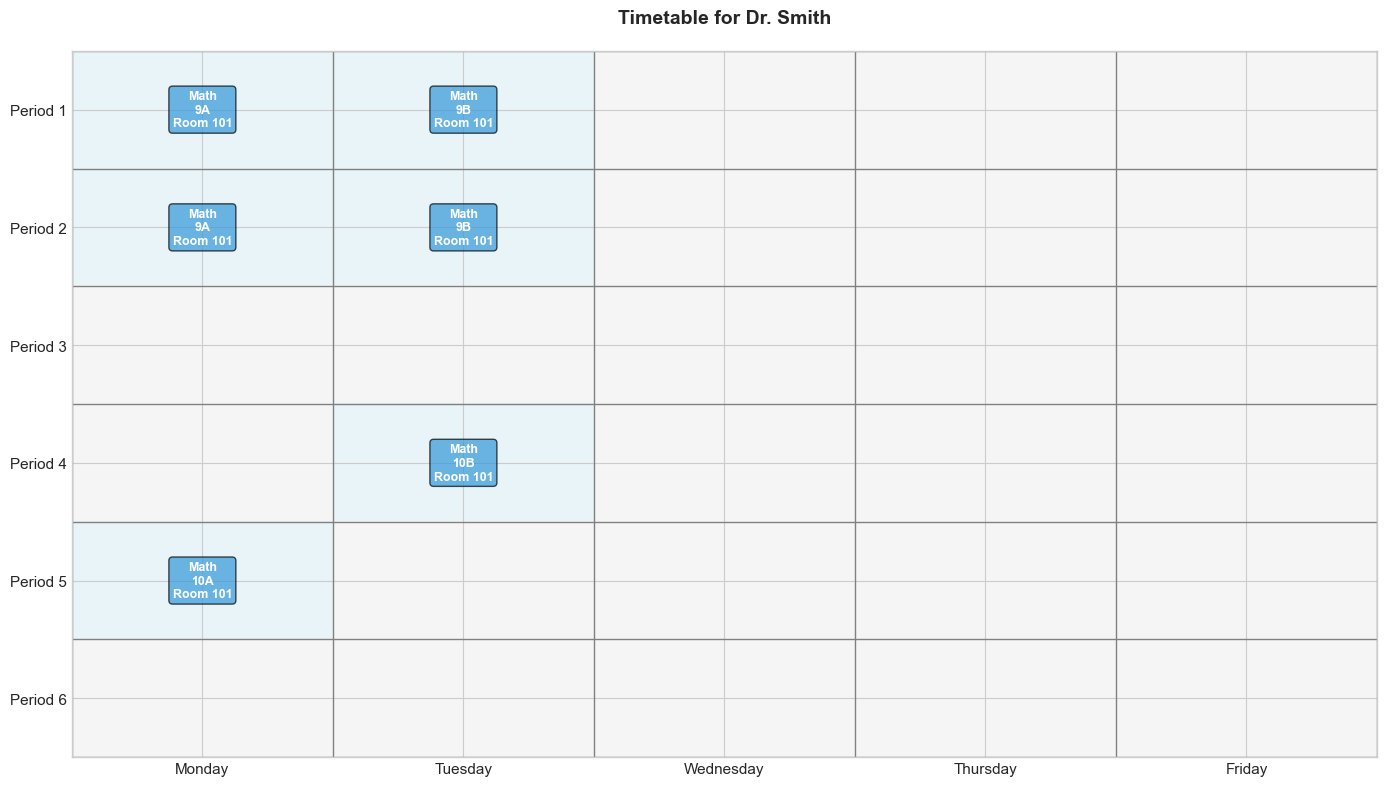

In [16]:
# Plot timetable for Dr. Smith (Teacher 1)
teacher = TEACHERS[0]
grid = create_timetable_matrix('teacher', teacher.id, teacher.name)
fig = plot_timetable(grid, f"Timetable for {teacher.name}")
plt.show()

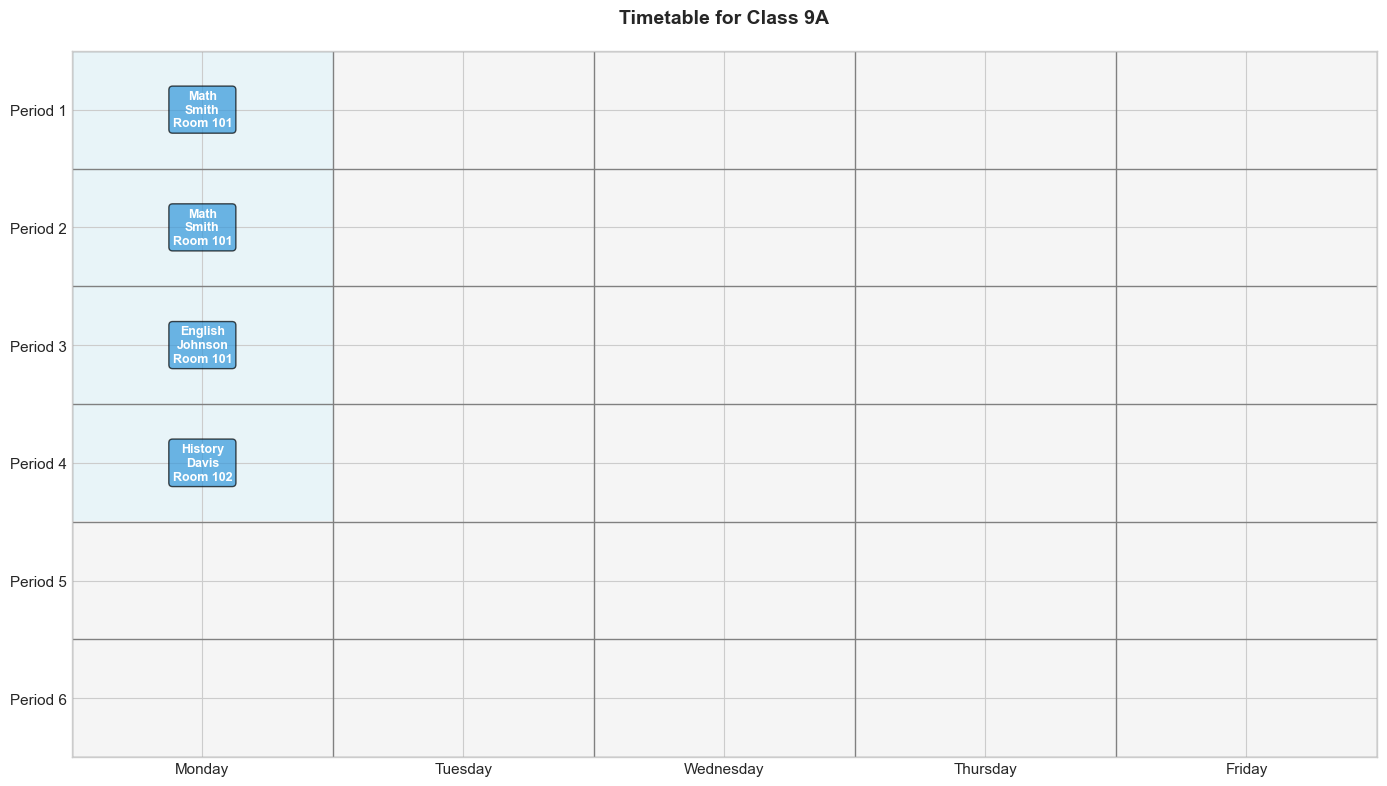

In [17]:
# Plot timetable for Class 9A
school_class = CLASSES[0]
grid = create_timetable_matrix('class', school_class.id, school_class.name)
fig = plot_timetable(grid, f"Timetable for Class {school_class.name}")
plt.show()

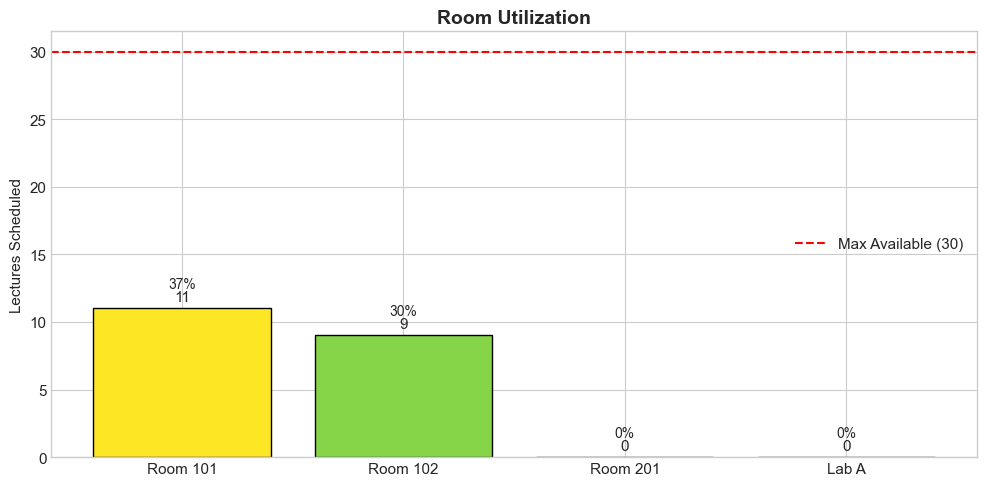

In [18]:
# Room utilization analysis
room_usage = {r.name: 0 for r in CLASSROOMS}
for (lecture_id, timeslot_id, classroom_id), value in schedule_data.items():
    room_name = CLASSROOM_BY_ID[classroom_id].name
    room_usage[room_name] += 1

fig, ax = plt.subplots(figsize=(10, 5))

rooms = list(room_usage.keys())
usage = list(room_usage.values())
max_slots = len(TIMESLOTS)  # 30 timeslots available

colors = plt.cm.viridis(np.array(usage) / max(usage))
bars = ax.bar(rooms, usage, color=colors, edgecolor='black')

ax.axhline(y=max_slots, color='red', linestyle='--', label=f'Max Available ({max_slots})')
ax.set_ylabel('Lectures Scheduled')
ax.set_title('Room Utilization', fontsize=14, fontweight='bold')
ax.bar_label(bars, padding=3)
ax.legend()

# Add utilization percentages
for i, (room, count) in enumerate(zip(rooms, usage)):
    pct = count / max_slots * 100
    ax.text(i, count + 1.5, f'{pct:.0f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## 7. Key Insights

### What We Learned

1. **3D Multi-Model Indexing**: Variables indexed by `(Lecture, TimeSlot, Classroom)` naturally represent the scheduling decision:
   - **What** (Lecture) is scheduled
   - **When** (TimeSlot) it occurs
   - **Where** (Classroom) it takes place

2. **Filtering with `where_multi()`**: Pre-filter infeasible combinations (class size > room capacity) to reduce model size.

3. **Multi-Dimensional Summation**: Build constraints by summing over specific dimensions:
   - Lecture coverage: sum over all timeslots and rooms
   - Room conflicts: sum over all lectures for a specific (timeslot, room)
   - Teacher conflicts: sum over teacher's lectures for a specific timeslot

4. **Feasibility Problem**: This is a constraint satisfaction problem - find any valid schedule without optimizing an objective.

### Pattern: 3D Multi-Model Variable

```python
assignment = (
    LXVariable[Tuple[ModelA, ModelB, ModelC], int]("name")
    .binary()
    .indexed_by_product(
        LXIndexDimension(ModelA, key_func).from_data(data_a),
        LXIndexDimension(ModelB, key_func).from_data(data_b),
        LXIndexDimension(ModelC, key_func).from_data(data_c),
    )
    .where_multi(lambda a, b, c: is_valid(a, b, c))
)
```

## 8. Extensions & Exercises

1. **Add more lectures**: Increase the number of sessions per subject
2. **Teacher availability**: Some teachers only available on certain days
3. **Consecutive periods**: Some subjects should be scheduled in consecutive slots
4. **Room preferences**: Certain subjects prefer specific room types
5. **Load balancing**: Distribute lectures evenly across the week

**Next notebook**: We'll add database integration with SQLAlchemy ORM.